In [1]:
import sys
sys.path.append("../") # go to parent dir

In [2]:
import pandas as pd
import seaborn as sn

from mimic3models.metrics import print_metrics_regression

In [3]:
period_bins = [5, 12, 24, 36, 48, 60, 72]

# [4 weeks, 2 weeks, 1 week, 3 days, 2.5 days, 2 days, 1.5 days, 1 day, .5 days]
remain_bins = [672, 336, 168, 72, 60, 48, 36, 24, 12]

In [4]:
df = pd.read_csv("/mnt/data01/models/lstm/regression/test_predictions/k_lstm.n64.d0.3.dep1.bs256.ts1.0.partition=none.chunk08.test1.2235.state.csv")
# df = pd.read_csv("/mnt/data01/models/linear_regression/logistic/cf_predictions/all.all.l2.C1e-05.csv")
# df = pd.read_csv("/mnt/data01/models/linear_regression/regression/predictions/all.all.csv")
df.describe(include="all")

,stay,period_length,prediction,y_true
count,525912,525912.000000,525912.000000,525912.000000
unique,6265,NaN,NaN,NaN
top,12805_episode1_timeseries.csv,NaN,NaN,NaN
freq,1988,NaN,NaN,NaN
mean,NaN,143.687375,79.475577,139.145741
std,NaN,202.474764,62.609560,202.464813
min,NaN,5.000000,0.000000,0.000000
25%,NaN,27.000000,24.447373,22.282400
50%,NaN,65.000000,53.176490,60.782000
75%,NaN,173.000000,138.008449,168.562400


In [5]:
# filter patients in the bottom and top 3%
stay_df = df.groupby(df.stay, as_index=False)["period_length"].agg("max")
print(stay_df.describe())
stay_df = stay_df[(stay_df.period_length > stay_df.period_length.quantile(.03)) & \
                  (stay_df.period_length < stay_df.period_length.quantile(.97))]
print(stay_df.describe())
df = df.merge(stay_df[["stay"]], how="inner", left_on="stay", right_on="stay")

#df.describe()

       period_length
count    6265.000000
mean       87.970790
std       127.748688
min         5.000000
25%        28.000000
50%        49.000000
75%        91.000000
max      1992.000000
       period_length
count    5839.000000
mean       72.739168
std        67.182868
min        17.000000
25%        29.000000
50%        49.000000
75%        86.000000
max       396.000000


In [6]:
df_list = []

period_df = df[df.period_length <= period_bins[0]].copy()
period_df["period_bin"] = period_bins[0]
df_list.append(period_df)

for bin in period_bins[1:]:
    period_df = df[df.period_length == bin].copy()
    period_df["period_bin"] = bin
    df_list.append(period_df)

period_df = pd.concat(df_list)
period_df.describe()

,period_length,prediction,y_true,period_bin
count,27849.000000,27849.000000,27849.000000,27849.000000
mean,28.040720,50.606249,63.813971,28.040720
std,20.835007,40.950945,70.305444,20.835007
min,5.000000,0.000000,0.000000,5.000000
25%,12.000000,21.526646,17.826400,12.000000
50%,24.000000,35.879932,38.599200,24.000000
75%,48.000000,64.908302,80.800800,48.000000
max,72.000000,188.474091,391.979200,72.000000


In [7]:
period_group_df = period_df.groupby("period_bin", as_index=False)["stay"].count()
period_group_df.head(10)

,period_bin,stay
0,5,5802
1,12,5832
2,24,5093
3,36,3888
4,48,3047
5,60,2334
6,72,1853


[Text(0.5, 0, 'LOS (Hours)'), Text(0, 0.5, 'Count')]

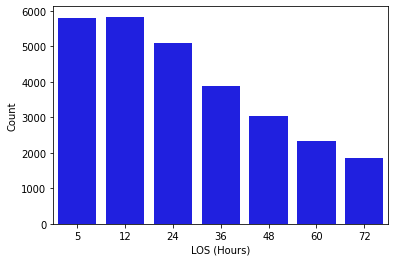

In [8]:
fig = sn.barplot(data=period_group_df, x="period_bin", y="stay", color="blue")
fig.set(xlabel='LOS (Hours)', ylabel='Count')

In [14]:
for bin in period_bins:
    metric_df = period_df[period_df.period_bin == bin].copy()
    print(f"\nMetrics at {bin} hours")
    print_metrics_regression(metric_df["y_true"], metric_df["prediction"], custom_bin=1)


Metrics at 5 hours
Custom bins confusion matrix:
[[1818 1373    0    0]
 [ 799 1327    0    0]
 [  73  316    0    0]
 [  11   85    0    0]]
Mean absolute deviation (MAD) = 40.13027160754912
Mean squared error (MSE) = 4258.691096361325
Mean absolute percentage error (MAPE) = 72.95564287846793
Cohen kappa score = 0.18988989576231863

Metrics at 12 hours
Custom bins confusion matrix:
[[2785  716    0    0]
 [1000  872    0    0]
 [  99  269    0    0]
 [  14   77    0    0]]
Mean absolute deviation (MAD) = 38.253028890775035
Mean squared error (MSE) = 3947.977022527121
Mean absolute percentage error (MAPE) = 90.32857534126687
Cohen kappa score = 0.27225313788174343

Metrics at 24 hours
Custom bins confusion matrix:
[[2813  426    1    0]
 [ 798  631   10    0]
 [  82  254    7    0]
 [   8   62    1    0]]
Mean absolute deviation (MAD) = 37.18829694364814
Mean squared error (MSE) = 3663.74300242855
Mean absolute percentage error (MAPE) = 206.90767031443505
Cohen kappa score = 0.3402855

In [10]:
# Remaining bins

df_list = []

for bin in remain_bins:
    remain_df = df[(df.y_true >= bin - 1) & (df.y_true < bin)].copy()
    remain_df["remain_bin"] = bin
    df_list.append(remain_df)

remain_df = pd.concat(df_list)
remain_df.describe()

,period_length,prediction,y_true,remain_bin
count,21186.000000,21186.000000,21186.000000,21186.000000
mean,67.697536,50.055746,37.162896,37.668649
std,71.358408,45.048823,32.092087,32.089033
min,5.000000,0.000000,11.000000,12.000000
25%,19.000000,20.239614,11.900800,12.000000
50%,41.000000,31.280144,35.065600,36.000000
75%,87.000000,60.677125,47.675200,48.000000
max,385.000000,191.696457,335.999200,336.000000


In [11]:
remain_group_df = remain_df.groupby("remain_bin", as_index=False)["stay"].count()
remain_group_df.head(10)

,remain_bin,stay
0,12,5837
1,24,4529
2,36,3658
3,48,2696
4,60,2209
5,72,1704
6,168,493
7,336,60


[Text(0.5, 0, 'LOS Remaining (Hours)'), Text(0, 0.5, 'Count')]

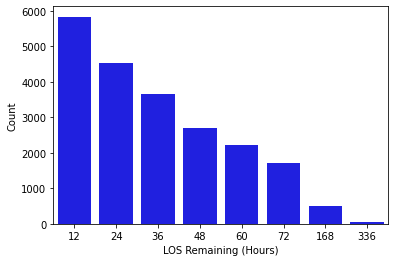

In [12]:
fig = sn.barplot(data=remain_group_df, x="remain_bin", y="stay", color="blue")
fig.set(xlabel='LOS Remaining (Hours)', ylabel='Count')

In [13]:
for bin in remain_bins:
    metric_df = remain_df[remain_df.remain_bin == bin].copy()
    if len(metric_df) == 0:
        continue
    print(f"\nMetrics at {bin} hours")
    print_metrics_regression(metric_df["y_true"], metric_df["prediction"], extra=True, custom_bin=1)





Metrics at 336 hours
Custom bins confusion matrix:
[[ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 8 47  5  0]]
Mean absolute deviation (MAD) = 228.8754308166667
Mean squared error (MSE) = 54314.08111954721
Mean absolute percentage error (MAPE) = 68.1944577973598
Cohen kappa score = 0.0
F1(micro) = 0.0
F1(macro) = 0.0
AUC = nan
Recall = 0.0
Accuracy = 0.0

Metrics at 168 hours
Custom bins confusion matrix:
[[  0   0   0]
 [107 262 124]
 [  0   0   0]]
Mean absolute deviation (MAD) = 62.3659893326572
Mean squared error (MSE) = 6451.197459998434
Mean absolute percentage error (MAPE) = 37.212802583896895
Cohen kappa score = 0.0
F1(micro) = 0.5314401622718052
F1(macro) = 0.2313465783664459
AUC = nan
Recall = 0.5314401622718052
Accuracy = 0.5314401622718052

Metrics at 72 hours
Custom bins confusion matrix:
[[  0   0   0]
 [801 738 165]
 [  0   0   0]]
Mean absolute deviation (MAD) = 47.04527085211268
Mean squared error (MSE) = 3053.838879170105
Mean absolute percentage error (MAPE) = 65.7